In [15]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_variant import Environment_DDPG 
from vehicle_model_ECMS import Environment_ECMS  
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
driver = Driver_MDP(0.02) 

num_states = 4 

In [13]:
def get_best_EF(env, EF_temp, threshold): 
    histories = {} 
    while True: 
        print(EF_temp)
        history = env.PMP_calculation(EF_temp)
        histories[EF_temp] = history 

        SOC_final = history["SOC_traj"][-1]
        fuel_consumption = np.sum(history["fc_traj"])
        print("Equivalent factor: {:.2f}, Final SOC: {:.4f}, fuel_consumption: {:.4f}".
              format(EF_temp, SOC_final, fuel_consumption))

        if abs(SOC_final - 0.6) < threshold: 
            break 

        EF_temp += 5 * (SOC_final - 0.6)

    return EF_temp, histories 

In [62]:
# driving_cycle_path = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'

# driving_cycle_paths = [
#     "../data/driving_cycles/all/01_FTP72_fuds.mat",
#     "../data/driving_cycles/all/00_nedc.mat", 
#     "../data/driving_cycles/all/cudec_freeway.mat",
# ] 
driving_cycle_paths = glob.glob("../data/driving_cycles/all/*.mat")
driving_cycle_path = driving_cycle_paths[4]
driving_cycle = sio.loadmat(driving_cycle_path)
driving_cycle = driving_cycle["sch_cycle"][:, 1]
env = Environment_ECMS(cell_model, driving_cycle, battery_path, motor_path)

EF_opt, histories = get_best_EF(env, -30, 0.01)

-30


C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\model_validation\vehicle_model_ECMS.py:182: RuntimeWarning: invalid value encountered in sqrt
  del_is = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * battery_powers) ** (0.5)) * (battery_powers < 0) \
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\model_validation\vehicle_model_ECMS.py:183: RuntimeWarning: invalid value encountered in sqrt
  + (1 / (2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * battery_powers) ** (0.5)) * (battery_powers >= 0)
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\model_validation\vehicle_model_ECMS.py:185: RuntimeWarning: invalid value encountered in greater
  del_SOCs[((i_lim_dis - del_is) * (i_lim_cha - del_is)) > 0] = np.nan


SOC is too low..
Equivalent factor: -30.00, Final SOC: 0.0049, fuel_consumption: 4.4012
-32.975610622981726
SOC is too low..
Equivalent factor: -32.98, Final SOC: 0.0049, fuel_consumption: 4.4012
-35.95122124596345
SOC is too low..
Equivalent factor: -35.95, Final SOC: 0.0048, fuel_consumption: 4.6212
-38.92710253246669
SOC is too low..
Equivalent factor: -38.93, Final SOC: 0.0047, fuel_consumption: 5.3250
-41.90360554014772
SOC is too low..
Equivalent factor: -41.90, Final SOC: 0.0043, fuel_consumption: 6.3368
-44.88218402207227
SOC is too low..
Equivalent factor: -44.88, Final SOC: 0.0036, fuel_consumption: 7.7886
-47.86435852483828
SOC is too low..
Equivalent factor: -47.86, Final SOC: 0.0039, fuel_consumption: 9.8563
-50.844744035559934
SOC is too low..
Equivalent factor: -50.84, Final SOC: 0.0049, fuel_consumption: 14.1235
-53.82036935961671
SOC is too low..
Equivalent factor: -53.82, Final SOC: 0.0049, fuel_consumption: 19.9746
-56.795999759505534
Equivalent factor: -56.80, Final

# Visualization Shooting method 

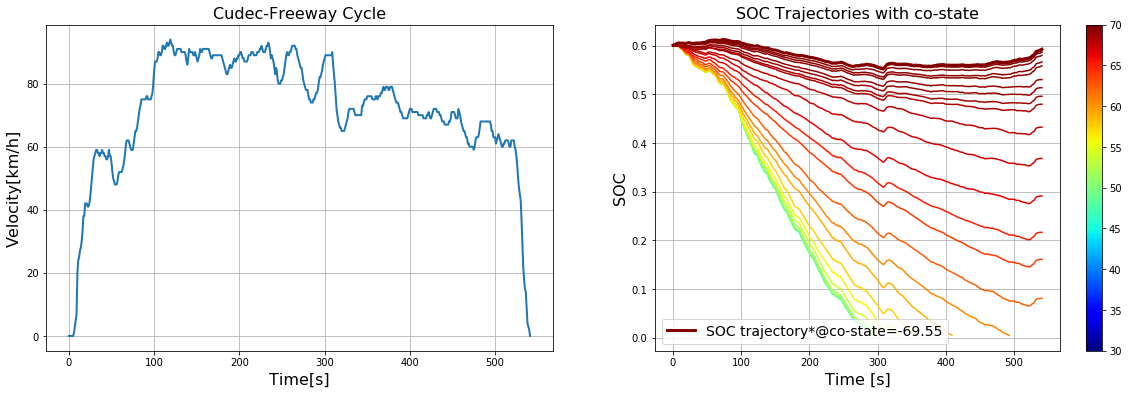

In [63]:
fig = plt.figure(figsize=(20, 6))
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin=30, vmax=70)

plt.subplot(1, 2, 1)
plt.plot(driving_cycle * 3.6, linewidth=2, )
plt.xlabel("Time[s]", fontsize=16)
plt.ylabel("Velocity[km/h]", fontsize=16)
plt.title("Cudec-Freeway Cycle", fontsize=16)
plt.grid() 

plt.subplot(1, 2, 2)
for EF, history in histories.items():
    color = cmap(EF / -70)
    if EF == EF_opt: 
        plt.plot(history["SOC_traj"], linewidth=3, c=color, label="SOC trajectory*@co-state={:.2f}".
                 format(EF))
    else: 
        plt.plot(history["SOC_traj"], c=color)

plt.legend(fontsize=14) 
plt.ylabel("SOC", fontsize=16)
plt.xlabel("Time [s]", fontsize=16)
plt.title("SOC Trajectories with co-state", fontsize=16)
plt.grid() 
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.savefig("ECMS Shooting method_Cudec.png")


In [5]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    
    
actor_model = get_actor() 

In [6]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [52]:
def test_model(cycle, model_path, EF, fig_title): 
#     test_cycle = driver.get_cycle() 
    env_ECMS = Environment_ECMS(cell_model, cycle, battery_path, motor_path)
    history_ECMS = env_ECMS.PMP_calculation(EF)
#     print(history_ECMS)
    
    env_DDPG = Environment_DDPG(cell_model, cycle, battery_path, motor_path, 10) 
    actor_model.load_weights(model_path)
    
    total_reward = 0 
    state = env_DDPG.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env_DDPG.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
#     SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    history_DDPG = env_DDPG.history 
    print("******************* Test is start *****************")
#     print(test_cycle)
#     print(history_ECMS["SOC_traj"][-1])
#     print(env_DDPG.fuel_consumption)
    final_SOC_ECMS = history_ECMS["SOC_traj"][-1]
    final_SOC_DDPG = history_DDPG["SOC"][-1] 
    FC_ECMS = np.sum(history_ECMS["fc_traj"])
    FC_DDPG = env_DDPG.fuel_consumption
    EQFC_ECMS = (0.6 - final_SOC_ECMS) * 67 + FC_ECMS 
    EQFC_DDPG = (0.6 - final_SOC_DDPG) * 67 + FC_DDPG
    
    print("final SOC for ECMS: {:.4f}, final SOC for DDPG: {:.4f}".format(
        final_SOC_ECMS, final_SOC_DDPG))
    print("FC for ECMS: {:.4f}, FC for DDPG: {:.4f}".format(FC_ECMS, FC_DDPG))
    print("EQFC for ECMS: {:.4f}, EQFC for DDPG: {:.4f}".format(EQFC_ECMS, EQFC_DDPG))
    print("******************* Test is done *****************")
    print("")
    
    
    
    plt.figure(figsize=(10, 6))
    
#     plt.subplot(2, 1, 1)
#     plt.plot(cycle * 3.6, linewidth=2, )
#     plt.ylabel("Velocity[km/h]", fontsize=16)
#     plt.grid() 
    
#     plt.subplot(2, 1, 2)
    plt.plot(history_ECMS["SOC_traj"], linewidth=2, label="SOC trajectory for ECMS") 
    plt.plot(history_DDPG["SOC"], linewidth=2, label="SOC trajectory for DDPG")
    
    plt.grid() 
    plt.xlabel("Time[s]", fontsize=16)
    plt.ylabel("SOC", fontsize=16)
    plt.legend(fontsize=14)
    plt.savefig("{}.png".format(fig_title))
    return history_DDPG 

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\model_validation\vehicle_model_ECMS.py:182: RuntimeWarning: invalid value encountered in sqrt
  del_is = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * battery_powers) ** (0.5)) * (battery_powers < 0) \
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\model_validation\vehicle_model_ECMS.py:183: RuntimeWarning: invalid value encountered in sqrt
  + (1 / (2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * battery_powers) ** (0.5)) * (battery_powers >= 0)
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\model_validation\vehicle_model_ECMS.py:185: RuntimeWarning: invalid value encountered in greater
  del_SOCs[((i_lim_dis - del_is) * (i_lim_cha - del_is)) > 0] = np.nan
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\model_validation\vehicle_model

maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.5926, final SOC for DDPG: 0.6054
FC for ECMS: 56.3090, FC for DDPG: 58.0455
EQFC for ECMS: 56.8032, EQFC for DDPG: 57.6861
******************* Test is done *****************



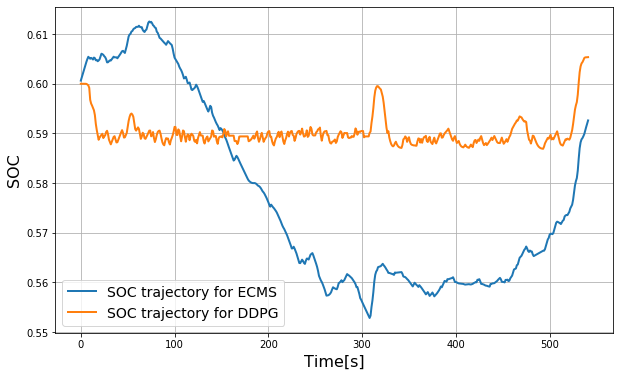

In [65]:
# training_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'

# test_cycles = [
#     "../data/driving_cycles/all/00_nedc.mat", 
#     "../data/driving_cycles/all/cudec_freeway.mat",
# ] 
# driving_cycle = sio.loadmat(training_cycle)
# driving_cycle = sio.loadmat(test_cycles[0])
# driving_cycle = driving_cycle["sch_cycle"][:, 1]

actor = "./DDPG_reference_trained_all_mass1200/actor_model.h5" 
# actor = "./DDPG_MDP_mass1200/actor_model.h5" 
history = test_model(driving_cycle, actor, EF_opt, "comparison_on_cudec_mass1200")